# Run script - gridded data to catchment timeseries

In this script we extract catchment timeseries of precipitation, potential evaporation and temperature from global gridded products. 

This scripts only works in the conda environment **sr_env**. In this environment all required packages are available. If you have **not** installed and activated this environment before opening this script, you should check the installation section in the *README* file. 

### 1. Getting started
First, import all the required packages.

In [1]:
# import packages
import glob
from pathlib import Path
import os
import geopandas as gpd
import iris
import iris.pandas
import numpy as np
from esmvalcore import preprocessor
from iris.coords import DimCoord
from iris.cube import Cube
from pathos.threading import ThreadPool as Pool
from datetime import datetime
from datetime import timedelta
# import cartopy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import xarray as xr
# import cartopy
import iris.plot as iplt
import matplotlib.pyplot as plt
import iris.quickplot as qplt

Here we import all the python functions defined in the scripts *f_grid_to_catchments.py*.

In [2]:
# import python functions
from f_grid_to_catchments import *

### 2. Define working and data directories
Here we define the working directory, where all the scripts and output are saved.

We also definet he data directory where you have the following subdirectories:

/data/forcing/*netcdf forcing files*\
/data/shapes/*catchment shapefiles*\
/data/gsim_discharge/*gsim discharge timeseries*


In [3]:
# Check current working directory (helpful when filling in work_dir below)
os.getcwd()

'/home/fransjevanoors/global_sr_module'

In [4]:
# define your script working directory
# work_dir=Path("/home/fransjevanoors/global_sr_module")
# work_dir=Path("/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module")
# define your data directory
# data_dir=Path("/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module/data")
work_dir=Path("/scratch/fransjevanoors/global_sr")

### 3. From gridded data to catchment timeseries
We don't have data on precipitation, potential evaporation and temperature at the catchment scale. Therefore, we use global gridded products of these parameters (there are a lot of possibilities which data to use). For doing analyses at the catchment scale, we need to convert these gridded products into catchment timeseries.
To do this, we calculate the mean parameter values of the gridcells that fall within the catchment shapes. The procedure is defined by the functions in the *f_grid_to_catchments.py* file.

In [5]:
# make output directories
if not os.path.exists(f'{work_dir}/output/forcing_timeseries/raw'):
    os.makedirs(f'{work_dir}/output/forcing_timeseries/raw')
if not os.path.exists(f'{work_dir}/output/forcing_timeseries/processed'):
    os.makedirs(f'{work_dir}/output/forcing_timeseries/processed')

In [6]:
# define directories 
SHAPE_DIR = Path(f'{data_dir}/shapes/') # dir of shapefiles
NC4_DIR = Path(f'{data_dir}/forcing/') # dir of netcdf forcing files
OUT_DIR = Path(f'{work_dir}/output/forcing_timeseries/raw') # output dir

The conversion from grid to catchment is computationally expensive. Therefore, we run this conversion for all catchments in parallel using the python function *pathos threadpool* (https://pathos.readthedocs.io/en/latest/pathos.html#module-pathos.threading).
With the *construct_lists_for_parallel_function* function from *f_grid_to_catchments.py* we create lists that contain all combinations of shapefile, netcdf-file and output-directory. OPERATOR LIST NOT NEEDED?. These lists are the input for the *run_function_parallel* function from *f_grid_to_catchments.py*, which returns timeseries of the catchment mean values of precipitation (P), potential evaporation (Ep) and  temperature (T). 

In [7]:
# Construct lists for parallel run
(shapefile_list, netcdf_list, operator_list, output_dir_list) = construct_lists_for_parallel_function(NC4_DIR, SHAPE_DIR, OUT_DIR)

In [8]:
# run function parallel
run_function_parallel(shapefile_list, netcdf_list, operator_list, output_dir_list)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

The output of the *run_function_parallel* function contains daily timeseries of P, Ep and T for all catchments. Here we postprocess these data to get dataframes containing Ep, P and T together with daily, monthly and yearly timeseries, climatology and mean values (stored as *csv* files). This postprocessing is done in the *process_forcing_timeseries* function defined in *f_grid_to_catchments.py*.

In [9]:
# define input directory
fol_in=f'{work_dir}/output/forcing_timeseries/raw'
# define output directory
fol_out=f'{work_dir}/output/forcing_timeseries/processed'

# get catch_id_list
catch_id_list = np.genfromtxt(f'{work_dir}/output/catch_id_list.txt',dtype='str')

# define variables
var = ['Ep','P','T']

# run process_forcing_timeseries (defined in f_grid_to_catchments.py) for all catchments in catch_id_list
for catch_id in catch_id_list:
    process_forcing_timeseries(catch_id,fol_in,fol_out,var)

In [10]:
# print P Ep T timeseries for catchment [0] in catch_id_list
catch_id = catch_id_list[0]
f = glob.glob(f'{fol_out}/daily/{catch_id}*.csv')
print(f)
c = pd.read_csv(f[0], index_col=0)
c.head()

['/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module/output/forcing_timeseries/processed/daily/br_0000495_1995_2000.csv']


,Ep,P,T
time,,,
1995-01-01,3.011033,0.004925,28.862823
1995-01-02,3.397685,0.000000,28.742493
1995-01-03,3.092484,0.000000,29.230500
1995-01-04,3.917221,0.000000,28.689178
1995-01-05,4.295576,0.019365,28.674103


## BEDROCK DEPTH

catchment mean, min, max, std bedrock depth

In [7]:
# define directories 
nc_bd = f'{work_dir}/data/bedrock_depth/BDTICM_M_005deg.nc' # dir of netcdf forcing files
out_dir = f'{work_dir}/output/bedrock_depth/0_05deg/' # output dir
operator = 'mean'

shape_dir = Path(f'{work_dir}/output/selected_shapes/')
shapefile_list = glob.glob(f'{shape_dir}/*.shp')[:]

netcdf_list = [nc_bd]*len(shapefile_list)
output_dir_list = [out_dir]*len(shapefile_list)

In [8]:
# run function parallel
run_bdepth_function_parallel(shapefile_list, netcdf_list, output_dir_list)

percentage of catchment gridpoints at 0.01 degree with bedrock < 100 cm

In [9]:
# define directories 
nc_bd = f'{work_dir}/data/bedrock_depth/BDTICM_M_001deg.nc' # dir of netcdf forcing files
out_dir = f'{work_dir}/output/bedrock_depth/0_01deg/' # output dir
operator = 'mean'

shape_dir = Path(f'{work_dir}/output/selected_shapes/')
shapefile_list = glob.glob(f'{shape_dir}/*.shp')[:]

netcdf_list = [nc_bd]*len(shapefile_list)
output_dir_list = [out_dir]*len(shapefile_list)

In [10]:
# run function parallel
run_bdepth_perc_function_parallel(shapefile_list, netcdf_list, output_dir_list)

In [11]:
#combine all files in one dataframe
# list al files
files = glob.glob(f"{work_dir}/output/bedrock_depth/0_01deg/*")
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    li.append(df) #append file to list
f = pd.concat(li, axis=0) #concatenate lists
f.to_csv(f'{work_dir}/output/bedrock_depth/all_catch_0_01_perc.csv')

In [15]:
fd = f[f.bd_perc>0.1]

In [16]:
fd

,bd_perc
ca_0003561,0.340168
G0050115,0.161083
ca_0004413,0.111513
ca_0005473,0.290076
304499,0.495536
...,...
mx_0000050,0.171759
ca_0003778,0.297876
ca_0005163,0.136578
401012,0.401891


## IWU IRRIGATION WATER USE

In [5]:
# define directories 
nc_bd = f'{work_dir}/data/IWU_irri_data/IWU_2011_2018.nc' # dir of netcdf forcing files
out_dir = f'{work_dir}/output/irrigation/raw/' # output dir
operator = 'mean'

shape_dir = Path(f'{work_dir}/output/selected_shapes/')
shapefile_list = glob.glob(f'{shape_dir}/*.shp')[0:15]

netcdf_list = [nc_bd]*len(shapefile_list)
output_dir_list = [out_dir]*len(shapefile_list)

In [ ]:
# run function parallel
run_iwu_function_parallel(shapefile_list, netcdf_list, output_dir_list) # run all catchments as job file

In [11]:
# process timeseries -> monthly to monthly means and yearly values
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:]

catch_id_list = list(catch_id_list)
work_dir_list = [work_dir]*len(catch_id_list)

In [12]:
run_iwu_processing_parallel(catch_id_list,work_dir_list) 

In [13]:
# combine mean values in one dataframe
# list al files
files = glob.glob(f"{work_dir}/output/irrigation/processed/mean/*")
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    li.append(df) #append file to list
f = pd.concat(li, axis=0) #concatenate lists
f.to_csv(f'{work_dir}/output/irrigation/mean_irrigation_all_catchments.csv')

In [14]:
f

,iwu_mean_mmday
za_0000167,0.010661
us_0006572,0.002885
de_0000129,0.009031
es_0000787,0.111952
br_0001831,0.002705
...,...
br_0001145,0.000517
138113A,0.008703
is_0000004,0.000000
br_0002204,0.011027


## IRRIGATED AREA

In [6]:
# catchment_netcdf = f'{work_dir}/data/irrigated_area/AEI_HYDE_FINAL_IR_2005_fraction.nc'
# catchment_netcdf = f'{work_dir}/data/irrigated_area/AEI_HYDE_FINAL_CP_2005_fraction.nc'
# catchment_netcdf = f'{work_dir}/data/irrigated_area/AEI_EARTHSTAT_CP_2005_fraction.nc'

irri_data = 'AEI_EARTHSTAT_IR_2005'
nc = f'{work_dir}/data/irrigated_area/{irri_data}_fraction.nc'
shape_dir = Path(f'{work_dir}/output/selected_shapes/')
out_dir =  f'{work_dir}/data/irrigated_area/output/{irri_data}/'

In [7]:
shape_dir = Path(f'{work_dir}/output/selected_shapes/')
shapefile_list = glob.glob(f'{shape_dir}/*.shp')[0:15]

netcdf_list = [nc]*len(shapefile_list)
out_dir_list = [out_dir]*len(shapefile_list)

In [9]:
run_irri_area_parallel(shapefile_list, netcdf_list, out_dir_list) # run all catchments as job file

In [6]:
def combine_irri_data(irri_data):
    i_list=[]
    for filepath in glob.iglob(f'{work_dir}/data/irrigated_area/output/{irri_data}/*.csv'):
        f = os.path.split(filepath)[1] # remove full path
        f = f[:-4] # remove .year extension
        i_list.append(f)

    df = pd.DataFrame(index=i_list, columns=[irri_data])
    for catch_id in i_list:
        if os.path.exists(f'{work_dir}/data/irrigated_area/output/{irri_data}/{catch_id}.csv'):
            d = pd.read_csv(f'{work_dir}/data/irrigated_area/output/{irri_data}/{catch_id}.csv',index_col=0)
            df.loc[catch_id] = d.iloc[0]
    df.to_csv(f'{work_dir}/data/irrigated_area/output/combined_ia_{irri_data}.csv')    

In [7]:
# irri_data = 'AEI_EARTHSTAT_IR_2005'
# combine_irri_data(irri_data)

# irri_data = 'AEI_EARTHSTAT_CP_2005'
# combine_irri_data(irri_data)

# irri_data = 'AEI_HYDE_FINAL_CP_2005'
# combine_irri_data(irri_data)

irri_data = 'AEI_HYDE_FINAL_IR_2005'
combine_irri_data(irri_data)

In [118]:
irri_data = 'AEI_EARTHSTAT_IR_2005'
ei = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia_{irri_data}.csv',index_col=0)

irri_data = 'AEI_EARTHSTAT_CP_2005'
ec = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia_{irri_data}.csv',index_col=0)

irri_data = 'AEI_HYDE_FINAL_CP_2005'
hi = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia_{irri_data}.csv',index_col=0)

irri_data = 'AEI_HYDE_FINAL_IR_2005'
hc = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia_{irri_data}.csv',index_col=0)

df = pd.DataFrame(index=ei.index, columns=['ei','ec','hi','hc'])
df['ei'] = ei
df['ec'] = ec
df['hi'] = hi
df['hc'] = hc
df.to_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv')    

In [119]:
# compare to GSIM ai data
dff = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = dff.ir_mean

df['gsim'] = ir

(0.0, 0.1)

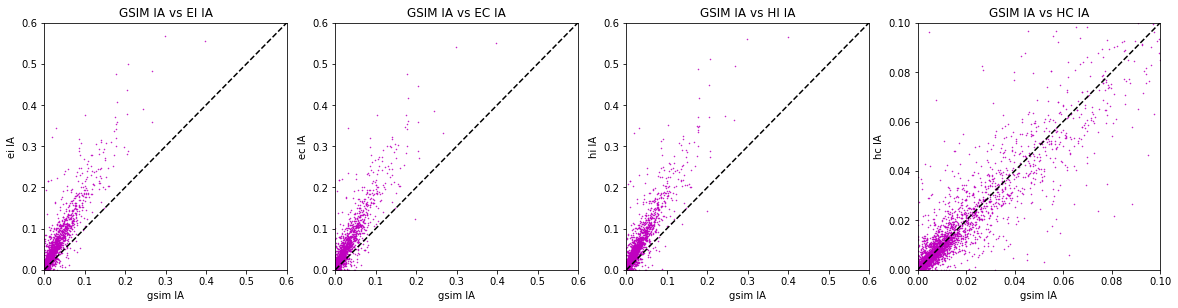

In [120]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(241)
ax.plot(df['gsim'], df['ei'], 'mo', markersize=0.5)
ax.plot([0,0.6],[0,0.6],'k--')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)
ax.set_title('GSIM IA vs EI IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('ei IA')

ax = fig.add_subplot(242)
ax.plot(df['gsim'], df['ec'], 'mo', markersize=0.5)
ax.plot([0,0.6],[0,0.6],'k--')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)
ax.set_title('GSIM IA vs EC IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('ec IA')

ax = fig.add_subplot(243)
ax.plot(df['gsim'], df['hi'], 'mo', markersize=0.5)
ax.plot([0,0.6],[0,0.6],'k--')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)
ax.set_title('GSIM IA vs HI IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('hi IA')

ax = fig.add_subplot(244)
ax.plot(df['gsim'], df['hc']/2, 'mo', markersize=0.5)
ax.plot([0,0.6],[0,0.6],'k--')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)
ax.set_title('GSIM IA vs HC IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('hc IA')
ax.set_ylim(0,0.1)
ax.set_xlim(0,0.1)


In [121]:
non_aus=[]
aus=[]
for i in df.index:
    if ('_' in i):
        non_aus.append(i)
    else:
        aus.append(i)
print('len aus: ',len(aus))
print('len non aus: ',len(non_aus))
print('len total: ',len(aus)+len(non_aus))

len aus:  222
len non aus:  8436
len total:  8658


(0.0, 0.05)

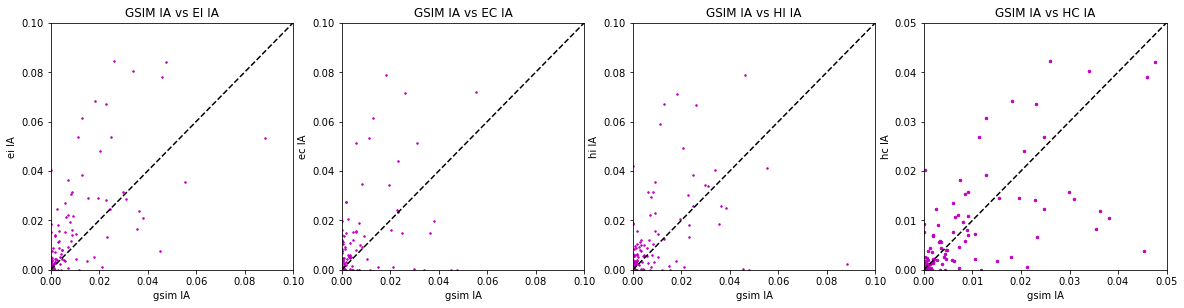

In [128]:
df = df.loc[aus]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(241)
ax.plot(df['gsim'], df['ei'], 'mo', markersize=1.5)
ax.plot([0,0.6],[0,0.6],'k--')
ax.set_ylim(0,0.1)
ax.set_xlim(0,0.1)
ax.set_title('GSIM IA vs EI IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('ei IA')

ax = fig.add_subplot(242)
ax.plot(df['gsim'], df['ec'], 'mo', markersize=1.5)
ax.plot([0,0.6],[0,0.6],'k--')
ax.set_ylim(0,0.1)
ax.set_xlim(0,0.1)
ax.set_title('GSIM IA vs EC IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('ec IA')

ax = fig.add_subplot(243)
ax.plot(df['gsim'], df['hi'], 'mo', markersize=1.5)
ax.plot([0,0.6],[0,0.6],'k--')
ax.set_ylim(0,0.1)
ax.set_xlim(0,0.1)
ax.set_title('GSIM IA vs HI IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('hi IA')

ax = fig.add_subplot(244)
ax.plot(df['gsim'], df['hc']/2, 'mo', markersize=2.5)
ax.plot([0,0.6],[0,0.6],'k--')
# ax.set_xlim(0,0.6)
# ax.set_ylim(0,0.6)
ax.set_title('GSIM IA vs HC IA')
ax.set_xlabel('gsim IA')
ax.set_ylabel('hc IA')
ax.set_ylim(0,0.05)
ax.set_xlim(0,0.05)


(0.0, 0.01)

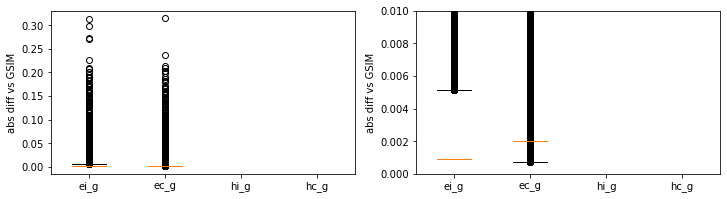

In [45]:
df_dif = pd.DataFrame(index=ei.index, columns=['ei_g','ec_g','hi_g','hc_g'])
df_dif['ei_g'] = df['ei'] - df['gsim']
df_dif['ec_g'] = df['ec'] - df['gsim']
df_dif['hi_g'] = df['hi'] - df['gsim']
df_dif['hc_g'] = df['hc'] - df['gsim']

df_difr = pd.DataFrame(index=ei.index, columns=['ei_g','ec_g','hi_g','hc_g'])
# df_difr['ei_g'] = (df['ei'] - df['gsim'])/df['gsim']
# df_difr['ec_g'] = (df['ec'] - df['gsim'])/df['gsim']
# df_difr['hi_g'] = (df['hi'] - df['gsim'])/df['gsim']
# df_difr['hc_g'] = (df['hc'] - df['gsim'])/df['gsim']

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(121)
ax.boxplot(df_dif)
ax.set_xticklabels(df_dif.columns)
ax.set_ylabel('abs diff vs GSIM')
# ax.set_ylim(-0.05,0.05)

ax = fig.add_subplot(122)
ax.boxplot(df_dif)
ax.set_xticklabels(df_dif.columns)
ax.set_ylabel('abs diff vs GSIM')
ax.set_ylim(0,0.01)

## MSWEP PRECIPITATION
Done on TinTin
Here: process timeseries

In [20]:
# all catchments
catch_list=[]
for filepath in glob.iglob(f'{work_dir}/output/forcing_timeseries/mswep_p/processed_timeseries/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-14] 
    catch_list.append(f)

# catchments done
c2 = []
for filepath in glob.iglob(f'{work_dir}/output/forcing_timeseries/mswep_p/processed/mean/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-14] 
    c2.append(f)
    
c3 = set(catch_list)-set(c2)
len(c3)

1771

In [21]:
catch_id_list = c3
work_dir_list = [work_dir] * len(catch_id_list)
run_mswep_processing_function_parallel(catch_id_list,work_dir_list)

In [19]:
# merge mswep mean values in dataframe 
files = glob.glob(f"{work_dir}/output/forcing_timeseries/mswep_p/processed/mean/*")[:]
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    f1 = filename.split('mean/')[1]
    f2 = f1.split('_1979_2019')[0]
    d = pd.DataFrame(index=[f2],columns=['mswep_mean_p'])
    d['mswep_mean_p'] = df['0'].values
    li.append(d) #append file to list
aw = pd.concat(li, axis=0) #concatenate lists
aw.to_csv(f"{work_dir}/output/forcing_timeseries/mswep_p/mean_p_mswep.csv")

## CRU PRECIPITATION - monthly

### run grid to catchments

In [8]:
# define directories 
nc_cru = f'{work_dir}/data/cru_p/cru_ts4.06_1961_2010_pre.nc' # dir of netcdf forcing files
out_dir = f'{work_dir}/output/forcing_timeseries/cru_p/area_weighted' # output dir
operator = 'mean'

shape_dir = Path(f'{work_dir}/output/selected_shapes/')
shapefile_list = glob.glob(f'{shape_dir}/*.shp')[0:5]

netcdf_list = [nc_cru]*len(shapefile_list)
output_dir_list = [out_dir]*len(shapefile_list)
operator_list = [operator]*len(shapefile_list)

In [ ]:
# run function parallel
run_cru_function_parallel(shapefile_list, netcdf_list, operator_list, output_dir_list)

### process timeseries

In [11]:
catch_id_list = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype=str)[:]
regrid_type='area_weighted'

work_dir_list = [work_dir]*len(catch_id_list)
regrid_type_list = [regrid_type]*len(catch_id_list)

run_cru_processing_function_parallel(catch_id_list,work_dir_list,regrid_type_list)

In [12]:
catch_id_list = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype=str)[:]
regrid_type='nearest_neighbour'

work_dir_list = [work_dir]*len(catch_id_list)
regrid_type_list = [regrid_type]*len(catch_id_list)

run_cru_processing_function_parallel(catch_id_list,work_dir_list,regrid_type_list)

In [29]:
# merge cru mean values in dataframe - area weighted
files = glob.glob(f"{work_dir}/output/forcing_timeseries/cru_p/area_weighted/processed/mean/*")[:]
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    f1 = filename.split('mean/')[1]
    f2 = f1.split('_1961')[0]
    d = pd.DataFrame(index=[f2],columns=['cru_mean_p_aw'])
    d['cru_mean_p_aw'] = df['0'].values
    li.append(d) #append file to list
aw = pd.concat(li, axis=0) #concatenate lists
aw.to_csv(f"{work_dir}/output/forcing_timeseries/cru_p/mean_p_area_weighted.csv")

In [30]:
# merge cru mean values in dataframe - nearest neighbour
files = glob.glob(f"{work_dir}/output/forcing_timeseries/cru_p/nearest_neighbour/processed/mean/*")[:]
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    f1 = filename.split('mean/')[1]
    f2 = f1.split('_1961')[0]
    d = pd.DataFrame(index=[f2],columns=['cru_mean_p_nn'])
    d['cru_mean_p_nn'] = df['0'].values
    li.append(d) #append file to list
nn = pd.concat(li, axis=0) #concatenate lists
nn.to_csv(f"{work_dir}/output/forcing_timeseries/cru_p/mean_p_nearest_neighbour.csv")

In [31]:
cb = pd.concat([aw,nn],axis=1)
cb.to_csv(f"{work_dir}/output/forcing_timeseries/cru_p/mean_p.csv")

In [32]:
cb

,cru_mean_p_aw,cru_mean_p_nn
ch_0000103,3.898726,3.890731
us_0002154,3.928862,3.923121
ca_0003144,1.139313,1.139023
us_0000227,3.305487,3.305487
de_0000803,1.962505,1.962505
...,...,...
ca_0000756,2.681718,2.672363
fr_0000894,2.470836,2.466738
br_0003043,5.130479,4.980619
ca_0001736,4.072753,4.085046


## CHIRPS PRECIPITATION - PROBLEMS

In [ ]:
# CHIRPS

In [5]:
nc_chirps = f'{work_dir}/data/chirps_p/chirps-v2.0.1981.days_p01.nc' # dir of netcdf forcing files
out_dir = f'{work_dir}/output/forcing_timeseries/chirps_p/area_weighted' # output dir
operator = 'mean'

shape_dir = Path(f'{work_dir}/output/selected_shapes/')
shapefile_list = glob.glob(f'{shape_dir}/*.shp')[0]

In [6]:
regrid_first=False #resolution is 0.05 degree, so very high

In [7]:
catchment_netcdf = nc_chirps
catchment_shapefile = shapefile_list
statistical_operator='mean'

In [8]:
catchment_netcdf

'/scratch/fransjevanoors/global_sr/data/chirps_p/chirps-v2.0.1981.days_p01.nc'

In [20]:
# Load iris cube of netcdf
cube = iris.load_cube(catchment_netcdf)
# cube.dim_coords[1].guess_bounds()
# cube.dim_coords[2].guess_bounds()

# extract dates of netcdf timeseries to be used as filename
time_start,time_end = cube.coord('time')[0],cube.coord('time')[-1]
point_start, point_end = time_start.points, time_end.points
unit = time_start.units
l = unit.num2date(0)
d = datetime(year=l.year, month=l.month, day=l.day)
date_start, date_end = d + timedelta(days=int(point_start[0])), d + timedelta(days=int(point_end[0]))
y_start, y_end = date_start.year, date_end.year

# Create target grid and regrid cube
if regrid_first is True:
    target_cube = regridding_target_cube(catchment_shapefile, grid_resolution, buffer=1) #create the regrid target cube
    # cube = preprocessor.regrid(cube, target_cube, scheme="area_weighted") #regrid the netcdf file (conservative) to a higher resolution
    cube = preprocessor.regrid(cube, target_cube, scheme="nearest") #regrid the netcdf file (nearest neighbour) to a higher resolution

cube.dim_coords[1].guess_bounds()
cube.dim_coords[2].guess_bounds()
# From cube extract shapefile shape
cube = preprocessor.extract_shape(cube, catchment_shapefile, method="contains") #use all grid cells that lie >50% inside the catchment shape

# Calculate area weighted statistics of extracted grid cells (inside catchment shape)
cube_stats = preprocessor.area_statistics(cube, statistical_operator)

# Convert cube to dataframe
df = iris.pandas.as_data_frame(cube_stats)

# Change column names of timeseries dataframe
df = df.reset_index()
df = df.set_axis(["time", cube_stats.name()], axis=1)

dates = pd.date_range(date_start,date_end + timedelta(days=31),freq='M')
df.index = dates
df = df.drop(columns='time')
df.precipitation = df.precipitation/df.index.days_in_month

var='p'
# Write csv as output
df.to_csv(f"{output_dir}/{Path(catchment_shapefile).name.split('.')[0]}_{var}_{statistical_operator}_{y_start}_{y_end}.csv")

ValueError: coordinate's range greater than coordinate's unit's modulus

In [17]:
# Load iris cube of netcdf
cube = iris.load_cube(catchment_netcdf)
# cube.dim_coords[1].guess_bounds()
# cube.dim_coords[2].guess_bounds()

In [18]:
cube

<iris 'Cube' of Climate Hazards group InfraRed Precipitation with Stations / (mm/day) (time: 365; latitude: 1800; longitude: 3600)>

In [12]:
cube.coord("longitude") 

DimCoord(array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.597e+02, 3.598e+02,
       3.599e+02]), bounds=array([[-5.0000e-02,  5.0000e-02],
       [ 5.0000e-02,  1.5000e-01],
       [ 1.5000e-01,  2.5000e-01],
       ...,
       [ 3.5965e+02,  3.5975e+02],
       [ 3.5975e+02,  3.5985e+02],
       [ 3.5985e+02,  3.5995e+02]]), standard_name='longitude', units=Unit('degrees'), long_name='longitude', var_name='lon')

In [13]:
cube.coord("latitude") 

DimCoord(array([-89.95, -89.85, -89.75, ...,  89.75,  89.85,  89.95]), bounds=array([[-90. , -89.9],
       [-89.9, -89.8],
       [-89.8, -89.7],
       ...,
       [ 89.7,  89.8],
       [ 89.8,  89.9],
       [ 89.9,  90. ]]), standard_name='latitude', units=Unit('degrees'), long_name='latitude', var_name='lat')

In [ ]:
## grid to catchments for cru precipitation
def area_weighted_shapefile_rasterstats_cru(
    catchment_shapefile,
    catchment_netcdf,
    statistical_operator,
    output_dir,
    output_csv=True,
    return_cube=False,
    regrid_first=True,
    grid_resolution=0.1
):
    
    """
    Calculate area weighted zonal statistics of netcdfs using a shapefile to extract netcdf data.

    catchment_shapefile:  str, catchment shapefile
    catchment_netcdf:     str, netcdf file
    statistical_operator: str, (mean, median (NOT area weighted), sum, variance, min, max, rms)
    - https://docs.esmvaltool.org/projects/esmvalcore/en/latest/api/esmvalcore.preprocessor.html#esmvalcore.preprocessor.area_statistics
    output_csv:          bool, True stores csv output and False stores netcdf output
    regrid_first:        bool, True regrid cube first before extracting shape, False do not regrid first
    grid_resolution:    float, grid cell size of target cube in degrees
    Returns: iris cube, stores .csv file or .nc file
    """

    # Load iris cube of netcdf
    cube = iris.load_cube(catchment_netcdf)
    cube.dim_coords[1].guess_bounds()
    cube.dim_coords[2].guess_bounds()

    # extract dates of netcdf timeseries to be used as filename
    time_start,time_end = cube.coord('time')[0],cube.coord('time')[-1]
    point_start, point_end = time_start.points, time_end.points
    unit = time_start.units
    l = unit.num2date(0)
    d = datetime(year=l.year, month=l.month, day=l.day)
    date_start, date_end = d + timedelta(days=int(point_start[0])), d + timedelta(days=int(point_end[0]))
    y_start, y_end = date_start.year, date_end.year

    # Create target grid and regrid cube
    if regrid_first is True:
        target_cube = regridding_target_cube(catchment_shapefile, grid_resolution, buffer=1) #create the regrid target cube
        # cube = preprocessor.regrid(cube, target_cube, scheme="area_weighted") #regrid the netcdf file (conservative) to a higher resolution
        cube = preprocessor.regrid(cube, target_cube, scheme="nearest") #regrid the netcdf file (nearest neighbour) to a higher resolution

    # From cube extract shapefile shape
    cube = preprocessor.extract_shape(cube, catchment_shapefile, method="contains") #use all grid cells that lie >50% inside the catchment shape

    # Calculate area weighted statistics of extracted grid cells (inside catchment shape)
    cube_stats = preprocessor.area_statistics(cube, statistical_operator)

    # Convert cube to dataframe
    df = iris.pandas.as_data_frame(cube_stats)

    # Change column names of timeseries dataframe
    df = df.reset_index()
    df = df.set_axis(["time", cube_stats.name()], axis=1)

    dates = pd.date_range(date_start,date_end + timedelta(days=31),freq='M')
    df.index = dates
    df = df.drop(columns='time')
    df.precipitation = df.precipitation/df.index.days_in_month

    var='p'
    # Write csv as output
    df.to_csv(f"{output_dir}/{Path(catchment_shapefile).name.split('.')[0]}_{var}_{statistical_operator}_{y_start}_{y_end}.csv")